In [ ]:
# Regularized Regression and Variance Control

# This project documents the systematic improvement of a regression model. The workflow transitions from 
# a baseline linear model to a regularized 
# Polynomial Ridge Regression model, utilizing target transformations and the One-Standard-Error (1-SE) rule
# to ensure maximum generalization.
    
# Project Evolution & Methodology
# 1. Baseline DiagnosticsInitial Performance: The starting model achieved a CV R2 of 0.47.
# Error Analysis: Residual Plot shows non constant variance - heteroscedasticity, a violation of linear regression
# assumptions.
        
# 2. Addressing Model Assumptions: To stabilize variance, a Yeo-Johnson transformation was applied to the target variable 
#     y. The post-transformation CV R2 was 0.44, 
    
# 3. Feature Engineering: Introducing higher order and interaction terms lead to a jump in features from  15 to 136.
#     This surge initially resulted in poorer metrics compared to the baseline. The is probably a feature of 
# overfitting or multicollinearity of feature. It is known from EDA that multiple features are correlated,
# poly features will most likely add to it. 
    
# 4. Regularization: Three Regularization Methods are employed. Lasso, Ridge, and Elastic Net.
# Grid search for alpha did not select the alpha with the best mean,
# instead, it selected an alpha value with mean value within one standard error from best_mean.
# Generally, this method will select an alpha higher than that with the best mean, allowing better 
# generalization. Ridge (L2) Emerged as the strongest candidate with a CV R2 of 0.52, five percentage 
# points higher than the base model CV R2.

# 5. Bootstrap: A bootstrap simulation was performed to verify model stability by looking at the 95 confidence interval of R2.
# Model showed a decent stability with bounds between 0.3 and 0.58. Out of Bag R2 was 0.53 which is very close
# to the CV R2 (0.52) as well as the test R2 (0.56). This consistency shows a solid model that is able
# to perform generalization on new data.

# 6. Feature Importance: Extracted Coefficients to assess feature importance. The
# top 20 features, the most influential 11 features were just main effect features while the 
# remaining 9 were a mix of interation and quadratic features. This confirmed that the relationship is non-linear 
# and some specific features combination are important for model performance, balancing bias-variance
# trade off.

# 7. Final Thoughts:
# a. Low bias in the baseline model: simplistic assumption that model function is linear while in reality, 
# relationship is non-linear.
    
# b. High variance: in an attempt to increase the model complexity, features with higher other degree were introduced
# which led to severe overfitting with metric performing significantly poorer than the simplistic baseline
# model. 
    
# c. Regularization: This process helped to recover performance by preventing overfitting, encouraging simplier models
# that generalize better. Instead of just selecting the alpha value with the best mean from a grid search,
# a 1-SE technique was employed to allow selection of larger alpha with a decent mean value (ie within 1 SE 
# of the best mean). This also allowed for better generalization on new data, ie a smaller alpha with a R2 
# of 0.52 will generalize as well as a larger alpha with a slightly lower mean of 0.511. Ridge (L2) regularization 
# performed slightly better than lasso and elastic net. This indicates that model performance is driven by 
# many predictors with small or medium-sized effects.
# Lastly, top 20 influencial features involves a combination of main, quadratic, and interaction effects,
# confirming the relationship as non linear.

# d. Next Steps: Exploring non-linear estimators like trees based methods and ensembles given that poly 
# terms were necessary to improve R2.

In [404]:
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy import stats

from sklearn.preprocessing import PowerTransformer, PolynomialFeatures, StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, KFold, cross_val_predict, cross_validate, LearningCurveDisplay, learning_curve
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.feature_selection import SelectFromModel
from sklearn.compose import TransformedTargetRegressor
from sklearn.base import clone

from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, ElasticNet
from sklearn.ensemble import BaggingRegressor

from sklearn.pipeline import Pipeline

In [405]:
RANDOM_STATE = 785
warnings.filterwarnings('ignore')

In [406]:
dta = pd.read_csv('./processed_data/processed_grains_data.csv')

In [407]:
dta.head()

,Unnamed: 0,file_name,area,Length,Width,perimeter,Mean_Red,Mean_Green,Mean_Blue,Mean_Hue,Aspect_Ratio,Roundness,Red_Green_Ratio,Green_Blue_Ratio,Red_Minus_Blue,Mean_Saturation,Mean_Lightness,type,score
0,0,F5Con_0pct,12512.992481,172.390563,92.595783,449.906274,210.534748,142.107249,72.636900,30.223461,1.867552,5.288429,1.484346,1.970300,137.897847,0.655405,0.825626,F5,0
1,1,F5Con_10pct,11874.452555,170.894055,88.593213,441.983805,218.657378,154.605206,84.739661,31.545044,1.949513,5.096029,1.428969,1.895520,133.917716,0.615825,0.857480,F5,10
2,2,F5Con_15pct,11830.110345,170.422248,88.656826,441.984596,219.440003,155.617710,85.983421,31.569533,1.941898,5.111073,1.426868,1.892416,133.456582,0.612160,0.860549,F5,15
3,3,F5Con_1pct,12362.430894,172.121654,91.741002,448.775056,212.999753,144.547159,74.286850,30.417118,1.912233,5.243356,1.477921,1.968887,138.712903,0.651804,0.835293,F5,1
4,4,F5Con_20pct,11774.364780,169.909934,88.199890,440.073484,217.016723,153.763019,84.529784,31.588248,1.943333,5.106454,1.426017,1.895793,132.486939,0.613109,0.851046,F5,20


In [408]:
dta.columns, dta.shape

(Index(['Unnamed: 0', 'file_name', 'area', 'Length', 'Width', 'perimeter',
        'Mean_Red', 'Mean_Green', 'Mean_Blue', 'Mean_Hue', 'Aspect_Ratio',
        'Roundness', 'Red_Green_Ratio', 'Green_Blue_Ratio', 'Red_Minus_Blue',
        'Mean_Saturation', 'Mean_Lightness', 'type', 'score'],
       dtype='object'),
 (957, 19))

In [409]:
y = dta['score']
X = dta.drop(columns = ['Unnamed: 0', 'type', 'score'])

In [410]:
Xtrain_df, Xtest_df, ytrain, ytest = train_test_split(X, y, test_size = 0.2, random_state = RANDOM_STATE)
Xtrain_df.shape, Xtest_df.shape

((765, 16), (192, 16))

In [411]:
Xtrain_df.columns

Index(['file_name', 'area', 'Length', 'Width', 'perimeter', 'Mean_Red',
       'Mean_Green', 'Mean_Blue', 'Mean_Hue', 'Aspect_Ratio', 'Roundness',
       'Red_Green_Ratio', 'Green_Blue_Ratio', 'Red_Minus_Blue',
       'Mean_Saturation', 'Mean_Lightness'],
      dtype='object')

In [412]:
ftrain = Xtrain_df['file_name']
ftest = Xtest_df['file_name']
Xtrain = Xtrain_df.drop(columns = ['file_name'])
Xtest = Xtest_df.drop(columns = ['file_name'])

In [413]:
# Xtest.head()

In [414]:
np.isinf(Xtrain).any()

area                False
Length              False
Width               False
perimeter           False
Mean_Red            False
Mean_Green          False
Mean_Blue           False
Mean_Hue            False
Aspect_Ratio        False
Roundness           False
Red_Green_Ratio     False
Green_Blue_Ratio    False
Red_Minus_Blue      False
Mean_Saturation     False
Mean_Lightness      False
dtype: bool

In [415]:
# 1. Run CV with a baseline regression model

In [416]:
baseline_mod = LinearRegression()

scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']
cv_score = cross_validate(baseline_mod, Xtrain, ytrain, cv = 5, scoring = scoring, return_train_score=False)
cv_r2 = np.mean(cv_score['test_r2'])
cv_rmse = np.sqrt(np.mean(-cv_score['test_neg_mean_squared_error']))
cv_mae = np.mean(-cv_score['test_neg_mean_absolute_error'])

metrics = {}
metrics['CV_R2'] = cv_r2
metrics['CV_RMSE'] = cv_rmse
metrics['CV_MAE'] = cv_mae
metrics

{'CV_R2': np.float64(0.4701914008960254),
 'CV_RMSE': np.float64(13.959123755426546),
 'CV_MAE': np.float64(10.268039914935965)}

In [417]:
# 1a. Generate Residuals from Xtrain

In [418]:
y_train_pred = cross_val_predict(baseline_mod, Xtrain, ytrain, cv = 5)
residuals = ytrain - y_train_pred
result_df = pd.DataFrame({
    'ytrain_pred': y_train_pred, 
    'ytrain' : ytrain,
    'residuals': residuals
})

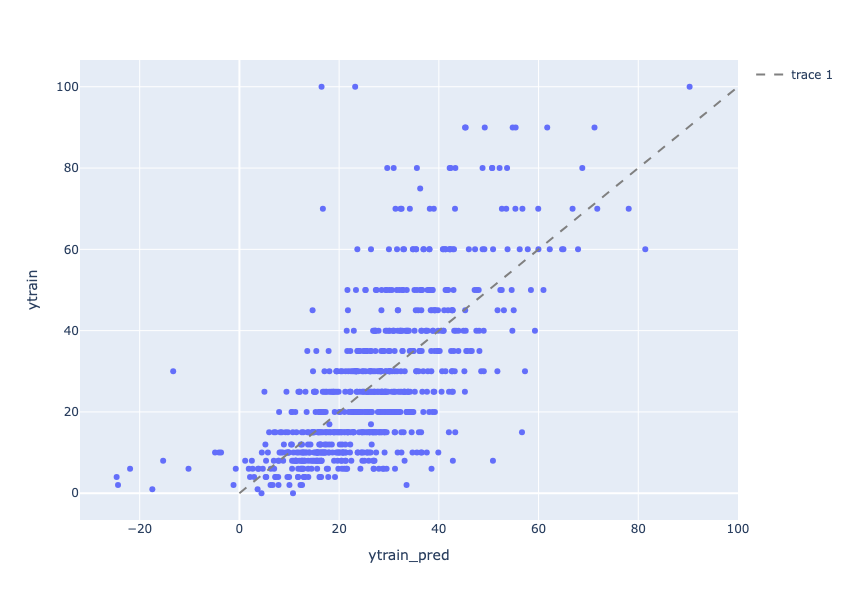

In [419]:
fig = px.scatter(result_df, x = 'ytrain_pred', y = 'ytrain', width=WIDTH, height=HEIGTH, )
fig.add_scatter(x = [0,100], y = [0, 100], mode = 'lines', line = dict(color = 'grey', dash = 'dash'))

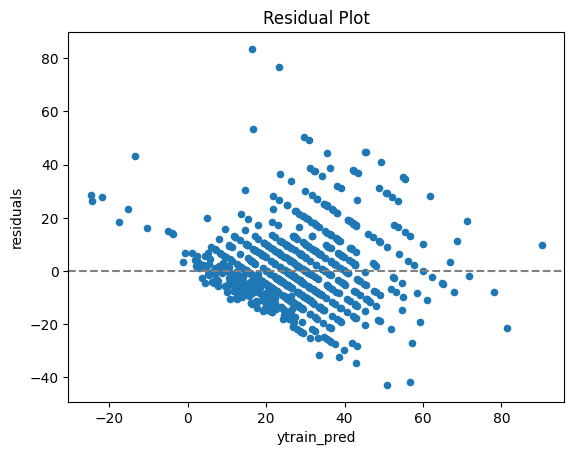

In [420]:
ax = result_df.plot.scatter(x = 'ytrain_pred', y = 'residuals', title = 'Residual Plot')
ax.axhline(y = 0, color = 'grey', linestyle = '--')

In [421]:
# 1b. Residual Plot shows non constant variance - heteroscedasticity, a violation of linear regression
# y target values are right skewed, necessitating Power Transform.

In [422]:
ytrain_df = pd.DataFrame({"y": ytrain})

<Axes: ylabel='Count'>

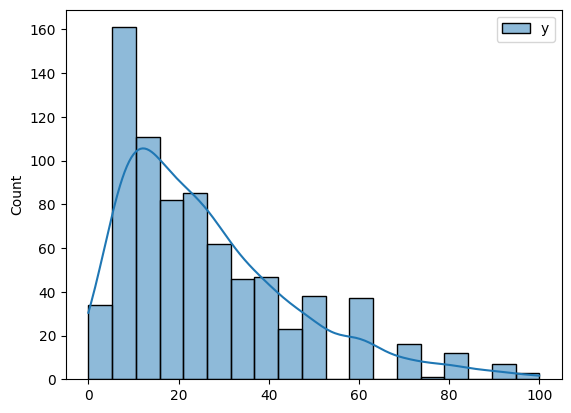

In [423]:
sns.histplot(ytrain_df, kde = True)

In [424]:
pt = PowerTransformer() # yeo-johnson
ytrain_yj = pt.fit_transform(ytrain_df)

<Axes: ylabel='Count'>

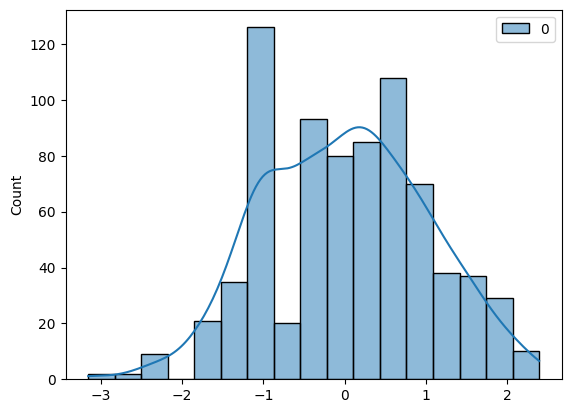

In [425]:
sns.histplot(ytrain_yj, kde = True)

In [426]:
scoring = {
    'r2' : 'r2',
    'mae' : 'neg_mean_absolute_error',
    'mse' : 'neg_mean_squared_error'
}

In [427]:
pipeline = Pipeline([
    ('power_x', PowerTransformer()),
    ('regressor', LinearRegression())
])

mod_inv = TransformedTargetRegressor(
    regressor = pipeline,
    transformer = PowerTransformer()
)


results = cross_validate(mod_inv, Xtrain, ytrain, cv = 5, scoring = scoring)
res = {}
res['cv_r2'] = results['test_r2'].mean()
res['cv_mae'] = -results['test_mae'].mean()
res['cv_rmse'] = np.sqrt(-results['test_mse'].mean())
res

{'cv_r2': np.float64(0.4434285990423059),
 'cv_mae': np.float64(9.917867595433417),
 'cv_rmse': np.float64(14.357966934046136)}

In [428]:
# 2. Power Transformation did not meet up with the baseline with R2 and RMSE. Small boost in MAE. 

In [429]:
# 2a.Poly features introduce to increase model complexity 

In [430]:
pipeline = Pipeline([
    ('power_x', PowerTransformer()),
    ('poly', PolynomialFeatures(degree=DEGREE)),
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

model_poly = TransformedTargetRegressor(
    regressor=pipeline,
    transformer=PowerTransformer()
)

results = cross_validate(model_poly, Xtrain, ytrain, cv = 5, scoring = scoring)
res = {}
res['cv_r2'] = results['test_r2'].mean()
res['cv_mae'] = -results['test_mae'].mean()
res['cv_rmse'] = np.sqrt(-results['test_mse'].mean())
res

{'cv_r2': np.float64(0.18756650940754382),
 'cv_mae': np.float64(10.770784533454414),
 'cv_rmse': np.float64(17.426771711132947)}

In [431]:
# 2b.Adding Poly Features led to poorer metrics compared to the baseline. The is probably a feature of 
# overfitting or multicollinearity of feature. I know from EDA that multiple features are correlated.
# Poly features will most likely add to it. 

In [432]:
# 3. Regularization.
# Three Regularization Methods are employed. Lasso, Ridge, and Elastic Net.
# NOTE on Regularization. Grid search for alpha did not select the alpha with the best mean,
# instead, it selected an alpha value with mean value within one standard error from best_mean.
# Generally, this method will select an alpha higher than that with the best mean, allowing better 
# generalization. 

In [433]:
# Utility function to process grid model, return input for plots as well as model metrics

def process_grid_results(cv_results, alphas, folds = 5):
        
    test_means = cv_results['mean_test_score']
    train_means = cv_results['mean_train_score']

    # do this check - mostly for Lasso
    mask = ~np.isnan(test_means)
    # mask_train = ~np.isnan(train_scores)
    
    a_plot = alphas[mask]
    s_test = test_means[mask]
    s_train = train_means[mask]

    test_stds = cv_results['std_test_score']
    se = test_stds/np.sqrt(folds)
    
    # Best Alpha - greedy approach
    best_idx = np.argmax(s_test)
    best_mean = s_test[best_idx]
    best_se = se[best_idx]

    # one std from test mean
    threshold = best_mean - best_se
    
    # simplest model - larger alpha lead to better generalization  
    possible_idx = np.where(s_test > threshold)[0]
    if possible_idx.size > 0:
        simplex_idx = possible_idx[np.argmax(alphas[possible_idx])]
    else: # in case there is a big dip after the best mean ie no mean with 1-SE, possible_idx will be empty
        simplex_idx = best_idx
    safer_a = alphas[simplex_idx]

    metrics = {}
    metrics['Validation_scores'] = s_test[simplex_idx]
    metrics['train_scores'] = s_train[simplex_idx]
    metrics['alpha'] = a_plot[simplex_idx]

    plotting = {}
    plotting['alpha_plot'] = a_plot
    plotting['test_means'] = s_test
    plotting['train_means'] = s_train
    plotting['best_mean'] = best_mean
    plotting['best_idx'] = best_idx
    plotting['safer_alpha'] = safer_a
    plotting['threshold'] = threshold

    return metrics, plotting

In [434]:
# Lasso

In [435]:
pipeline = Pipeline([
    ('power_x', PowerTransformer()),
    ('poly', PolynomialFeatures(degree = DEGREE)),
    ('scaler', StandardScaler()),
    ('selection', SelectFromModel(Lasso(max_iter=10000))),
    ('regressor', LinearRegression())
])

params = {
    'regressor__selection__estimator__alpha' : np.logspace(-4, 1, 50)
}

pipe_mod = TransformedTargetRegressor(
    regressor=pipeline,
    transformer=PowerTransformer()
)

grid_search = GridSearchCV(pipe_mod, params, cv = 5, scoring = 'r2', return_train_score=True)
grid_search.fit(Xtrain, ytrain)

res = grid_search.cv_results_
alphas = res['param_regressor__selection__estimator__alpha'].data.astype(float)

metrics, plotting_dta = process_grid_results(res, alphas)
metrics


{'Validation_scores': np.float64(0.4778108234260632),
 'train_scores': np.float64(0.5383153026892662),
 'alpha': np.float64(0.004291934260128779)}

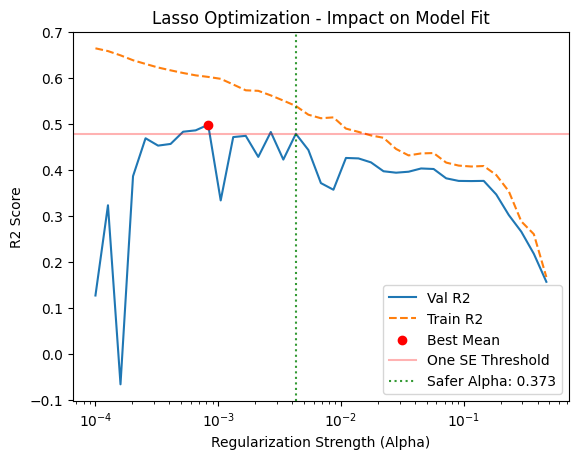

In [436]:
best_idx = plotting_dta['best_idx']
a_plot = plotting_dta['alpha_plot']

plt.semilogx(a_plot, plotting_dta['test_means'], label = 'Val R2')
plt.semilogx(a_plot, plotting_dta['train_means'], label = 'Train R2', linestyle = '--')

plt.scatter(a_plot[best_idx], plotting_dta['best_mean'], color = 'red', zorder = 5, label = 'Best Mean')

plt.axhline(plotting_dta['threshold'], color = 'red', linestyle = '-', alpha = 0.3, label = 'One SE Threshold')
plt.axvline(plotting_dta['safer_alpha'], color = 'green', linestyle = ':', alpha = 0.8, label = f'Safer Alpha: {safer_a:.3f}')

# best_idx = np.argmax(s_test_r)
# plt.axvline(a_plot_r[best_idx], color = 'purple', linestyle = ':', alpha = 0.8, label=f'Best Alpha: {a_plot_r[best_idx]:.2e}')
plt.ylabel('R2 Score')
plt.xlabel('Regularization Strength (Alpha)')
plt.title('Lasso Optimization - Impact on Model Fit')
plt.legend()

In [ ]:
# Ridge

In [437]:
pipeline = Pipeline([
    ('power_x', PowerTransformer()),
    ('poly', PolynomialFeatures(degree = DEGREE)),
    ('scaler', StandardScaler()),
    ('ridge', Ridge(random_state=RANDOM_STATE)),
    # ('regressor', LinearRegression())
])

params = {
    'regressor__ridge__alpha' : np.logspace(-4, 1, 50)
}

pipe_mod = TransformedTargetRegressor(
    regressor=pipeline,
    transformer=PowerTransformer()
)

grid_ridge = GridSearchCV(pipe_mod, params, cv = 5, scoring = 'r2', return_train_score=True)
grid_ridge.fit(Xtrain, ytrain)

cv_res = grid_ridge.cv_results_
alphas = cv_res['param_regressor__ridge__alpha'].data.astype(float)

metrics, plotting_dta = process_grid_results(cv_res, alphas)
metrics

{'Validation_scores': np.float64(0.5190683093166593),
 'train_scores': np.float64(0.5975251030431112),
 'alpha': np.float64(0.3727593720314942)}

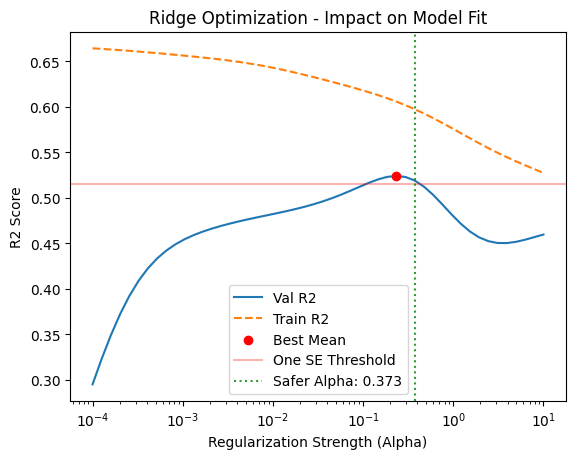

In [438]:
best_idx = plotting_dta['best_idx']
a_plot = plotting_dta['alpha_plot']

plt.semilogx(a_plot, plotting_dta['test_means'], label = 'Val R2')
plt.semilogx(a_plot, plotting_dta['train_means'], label = 'Train R2', linestyle = '--')

plt.scatter(a_plot[best_idx], plotting_dta['best_mean'], color = 'red', zorder = 5, label = 'Best Mean')

plt.axhline(plotting_dta['threshold'], color = 'red', linestyle = '-', alpha = 0.3, label = 'One SE Threshold')
plt.axvline(plotting_dta['safer_alpha'], color = 'green', linestyle = ':', alpha = 0.8, label = f'Safer Alpha: {safer_a:.3f}')

plt.ylabel('R2 Score')
plt.xlabel('Regularization Strength (Alpha)')
plt.title('Ridge Optimization - Impact on Model Fit')
plt.legend()

In [439]:
# ElasticNet

In [440]:
pipeline = Pipeline([
    ('power_x', PowerTransformer()),
    ('poly', PolynomialFeatures(degree = DEGREE)),
    ('scaler', StandardScaler()),
    ('en', ElasticNet(max_iter=1000)),
    # ('regressor', LinearRegression())
])

params = {
    'regressor__en__alpha' : np.logspace(-4, 1, 50),
    'regressor__en__l1_ratio' : np.linspace(0.1, 0.9, 9)
}

pipe_mod = TransformedTargetRegressor(
    regressor=pipeline,
    transformer=PowerTransformer()
)

grid_en = GridSearchCV(pipe_mod, params, cv = 5, scoring = 'r2', return_train_score=True)
grid_en.fit(Xtrain, ytrain)

res_en = grid_en.cv_results_
alphas = res_en['param_regressor__en__alpha'].data.astype(float)

metrics, plotting_dta = process_grid_results(res_en, alphas)
metrics


{'Validation_scores': np.float64(0.5019417872207151),
 'train_scores': np.float64(0.5803059793336012),
 'alpha': np.float64(0.0010481131341546852)}

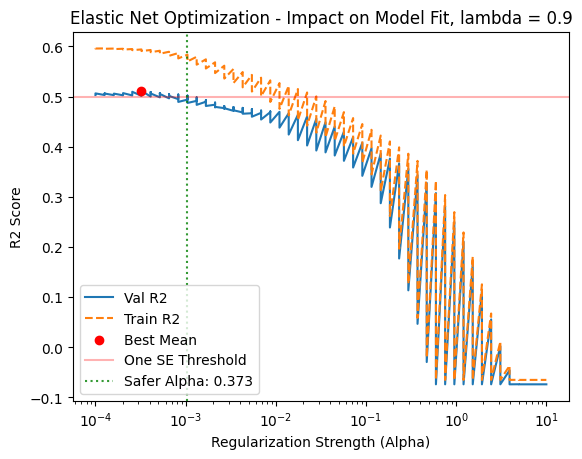

In [441]:
best_idx = plotting_dta['best_idx']
a_plot = plotting_dta['alpha_plot']

plt.semilogx(a_plot, plotting_dta['test_means'], label = 'Val R2')
plt.semilogx(a_plot, plotting_dta['train_means'], label = 'Train R2', linestyle = '--')

plt.scatter(a_plot[best_idx], plotting_dta['best_mean'], color = 'red', zorder = 5, label = 'Best Mean')

plt.axhline(plotting_dta['threshold'], color = 'red', linestyle = '-', alpha = 0.3, label = 'One SE Threshold')
plt.axvline(plotting_dta['safer_alpha'], color = 'green', linestyle = ':', alpha = 0.8, label = f'Safer Alpha: {safer_a:.3f}')

plt.ylabel('R2 Score')
plt.xlabel('Regularization Strength (Alpha)')
plt.title(f"Elastic Net Optimization - Impact on Model Fit, lambda = {grid_en.best_params_['regressor__en__l1_ratio']}")
plt.legend()

In [ ]:
# 3a.Final Model Training on Ridge L2 Regularization. This model produced the largest CV R2. This metric
# is five percentage points higher than the base model CV R2.

In [442]:
final_model = clone(grid_ridge.best_estimator_)
final_model.set_params(regressor__ridge__alpha = safer_a)
final_model.fit(Xtrain, ytrain)
pred = final_model.predict(Xtest)
r2 = r2_score(ytest, pred)
mae = mean_absolute_error(ytest, pred)
rmse = np.sqrt(mean_squared_error(ytest, pred))
r2, mae, rmse

(0.5595430653899778, 9.18941434063592, np.float64(12.542333075766988))

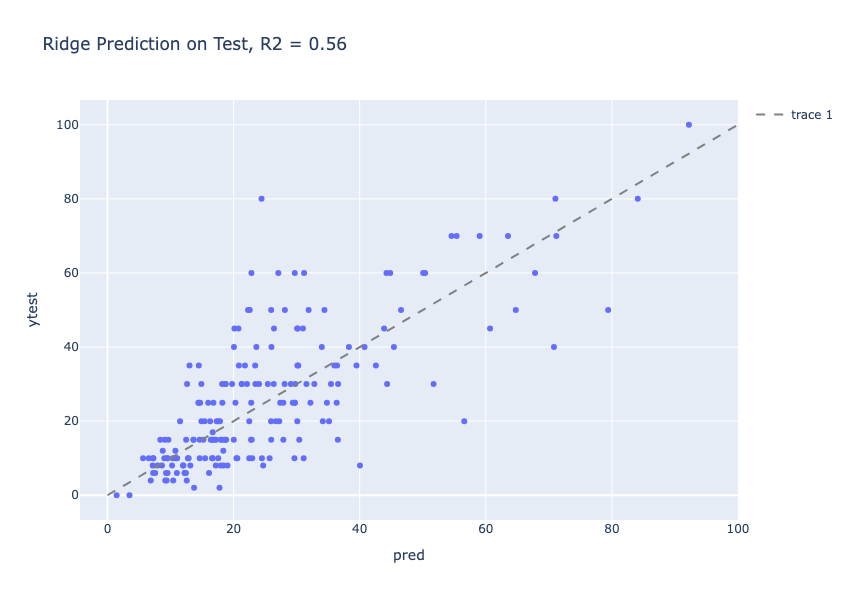

In [443]:
results_df = pd.DataFrame({
    'pred' : pred,
    'ytest' : ytest,
    'fname' : ftest,
    'residual' : ytest - pred
})

fig = px.scatter(results_df, x = 'pred', y = 'ytest', hover_data = 'fname', width=WIDTH, height=HEIGTH, title='Ridge Prediction on Test, R2 = 0.56')
fig.add_scatter(x = [0,100], y = [0, 100], mode = 'lines', line = dict(color = 'grey', dash = 'dash'))

array([[<Axes: title={'center': 'residual'}>]], dtype=object)

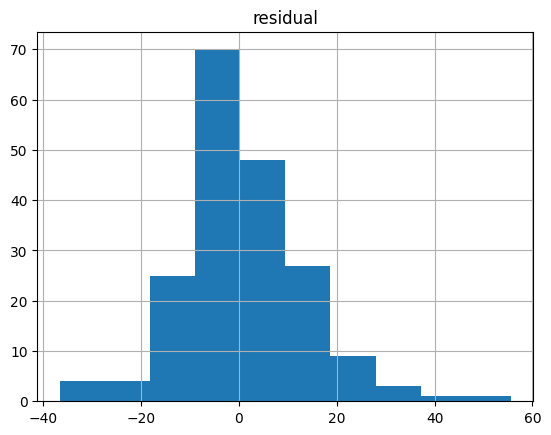

In [444]:
results_df.hist('residual')

In [ ]:
# 3b.Model performed well on the test set, 56% R2 value, 9.19 MAE.

In [ ]:
# 4. Bootstrap simulation to verify model stability by looking at the 95 confidence interval of R2.

In [446]:
safe_ridge = clone(grid_ridge.best_estimator_)
safe_ridge.set_params(regressor__ridge__alpha=safe_alpha)

bootstrap_model = BaggingRegressor(
    estimator=safe_ridge,
    n_estimators=1000,
    max_samples=1.0,
    bootstrap=True,
    oob_score=True,
    random_state=RANDOM_STATE
)

bootstrap_model.fit(Xtrain, ytrain)

scores = []
for estimator in bootstrap_model.estimators_:
    scores.append(estimator.score(Xtrain, ytrain))

In [447]:
mean_r2 = np.mean(scores)
ci_lower = np.percentile(scores, 2.5)
ci_upper = np.percentile(scores, 97.5)
d = {}
d['Mean_R2 OOB'] = mean_r2
d['ci_lower'] = ci_lower
d['ci_upper'] = ci_upper
d

{'Mean_R2 OOB': np.float64(0.5316070882762716),
 'ci_lower': np.float64(0.299536548472049),
 'ci_upper': np.float64(0.5835223603493652)}

array([[<Axes: title={'center': 'scores'}>]], dtype=object)

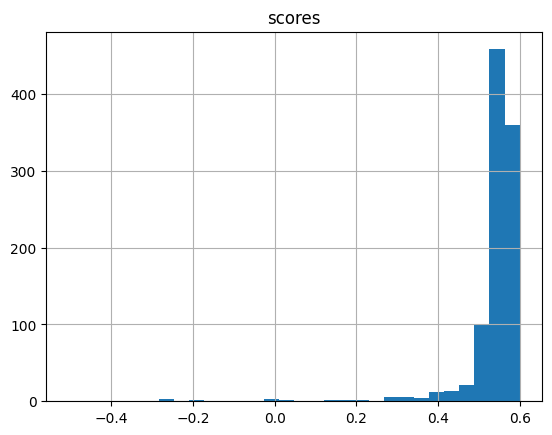

In [448]:
scores_df = pd.DataFrame({
    'scores' : scores
})
scores_df.hist('scores', bins = 30)

In [ ]:
# 4a. Model showed a decent stability with bounds between 0.3 and 0.58. Out of Bag R2 was 0.53 which is very close
# to the CV R2 (0.52) as well as the test R2 (0.56). This consistency shows a solid model that is able
# to perform generalization on new data.

In [ ]:
# 5. Lastly, Extracted Coefficients to assess feature importance.

In [449]:

best_model = grid_ridge.best_estimator_

column_names = Xtrain.columns.tolist()

poly_estimator = best_model.regressor_['poly']
fe_names = poly_estimator.get_feature_names_out(input_features = column_names)

print(f'Total Poly Features: {len(fe_names)}')
coefs = best_model.regressor_['ridge'].coef_

imp_df = pd.DataFrame({
    'Feature': fe_names,
    'Coefficient': coefs
})


imp_df['Abs_Coefficient'] = imp_df['Coefficient'].abs()
imp_df = imp_df.sort_values(by='Abs_Coefficient', ascending=False)

imp_df.head(15)

Total Poly Features: 136


,Feature,Coefficient,Abs_Coefficient
1,area,-2.837606,2.837606
4,perimeter,2.231135,2.231135
12,Green_Blue_Ratio,1.996498,1.996498
7,Mean_Blue,1.927256,1.927256
3,Width,1.924982,1.924982
6,Mean_Green,1.879691,1.879691
13,Red_Minus_Blue,-1.877196,1.877196
11,Red_Green_Ratio,1.789327,1.789327
8,Mean_Hue,1.702794,1.702794
2,Length,-1.431127,1.431127


Text(0.5, 1.0, 'Top 20 Features - Ridge Model')

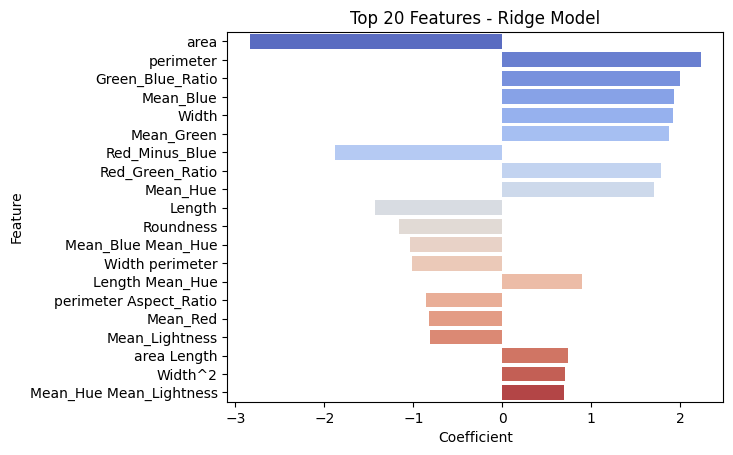

In [450]:
sns.barplot(imp_df.head(20), x='Coefficient', y='Feature', palette='coolwarm')
plt.title('Top 20 Features - Ridge Model')

In [ ]:
# 5a. For top 20 features, the most influential 11 features were just main effect features while the 
# remaining 9 were a mix of interation and quadratic features. This confirmed that the relationship is non-linear 
# and some specific features combination are important for model performance, balancing bias-variance
# trade off.


In [ ]:
# 6. Final Thoughts:
# Low bias in the baseline model: simplistic assumption that model function is linear while in reality, 
# relationship is non-linear.
# High variance: in an attempt to increase the model complexity, features with higher other degree were introduced
# which led to severe overfitting with metric performing significantly poorer than the simplistic baseline
# model. 
# Regularization: This process helped to recover performance by preventing overfitting, encouraging simplier models
# that generalize better. Instead of just selecting the alpha value with the best mean from a grid search,
# a 1-SE technique was employed to allow selection of larger alpha with a decent mean value (ie within 1 SE 
# of the best mean). This also allowed for better generalization on new data, ie a smaller alpha with a R2 
# of 0.52 will generalize as well as a larger alpha with a slightly lower mean of 0.511. Ridge (L2) regularization 
# performed slightly better than lasso and elastic net. This indicates that model performance is driven by 
# many predictors with small or medium-sized effects.
# Lastly, top 20 influencial features involves a combination of main, quadratic, and interaction effects,
# confirming the relationship as non linear.

# 7. Next Steps
# Exploring non-linear estimators like trees based methods and ensembles given that poly terms were
# necessary to improve R2.